In [1]:
import utils
import prepare_datasets_for_ML as preparation

import os
import optuna
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler


np.random.seed(42)

In [2]:
def preprocess_image_for_ML(image, mask, manual, sliding_window_size, sliding_window_step):
    preprocessed_image, preprocessed_mask, preprocessed_manual = preparation.set_of_images_preprocessing(image, mask, manual)
    features, labels = preparation.sliding_window(preprocessed_image, preprocessed_manual, window_size=sliding_window_size, step=sliding_window_step)
    
    df = pd.DataFrame(features, columns=['Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5', 'Hu6', 'Hu7',
                                      'Red_mean', 'Red_var', 'Green_mean', 'Green_var',
                                      'Blue_mean', 'Blue_var'])
    df["label"] = labels
    
    return df, preprocessed_mask

def process_predicted_image(y_pred, preprocessed_mask, width, height):
    scalled_mask = cv.resize(preprocessed_mask, dsize=(height, width), interpolation=cv.INTER_NEAREST)
    corrected_image = np.reshape(y_pred*scalled_mask.flatten(), (width , height))
    _, thresholded_image = cv.threshold(corrected_image, 0.5, 1, cv.THRESH_BINARY)
    
    return thresholded_image

# Load Data

In [3]:
curr_dir_path = os.path.abspath('')
data_dir_path = os.path.join(curr_dir_path, "data")

train = pd.read_csv(os.path.join(data_dir_path, "train.csv"))
test = pd.read_csv(os.path.join(data_dir_path, "test.csv"))

# Sample train and test

## Train

In [4]:
train_size = train.shape[0]
print(f"Train dataset size: {train_size}")

test_size = test.shape[0]
print(f"Test dataset size: {test_size}")

train = shuffle(train).reset_index(drop=True)
test = shuffle(test).reset_index(drop=True)

X_train = train.loc[:train_size//20, train.columns.difference(['label'])]
y_train = train.loc[:train_size//20, 'label']
rus = RandomUnderSampler(sampling_strategy=0.3)
X_train, y_train = rus.fit_resample(X_train, y_train)

X_valid = train.loc[train_size//20: train_size//14, train.columns.difference(['label'])]
y_valid = train.loc[train_size//20: train_size//14, 'label']
X_valid, y_valid = rus.fit_resample(X_valid, y_valid)

X_test = test.loc[:test_size//20, test.columns.difference(['label'])]
y_test = test.loc[:test_size//20, 'label']

Train dataset size: 10781697
Test dataset size: 1658541


In [5]:
y_train.value_counts()

0.0    166336
1.0     49901
Name: label, dtype: int64

In [6]:
clf = xgb.XGBClassifier()

clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [7]:
pred = clf.predict(X_valid)
utils.print_metrics(y_valid, pred)

Confusion matrix:

  13164   |   7944   
--------------------
   3327   |  67033   

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.89      0.80      0.92      0.84      0.72     74977
          1       0.62      0.80      0.89      0.70      0.84      0.71     16491

avg / total       0.89      0.88      0.82      0.88      0.84      0.72     91468



## Test

In [8]:
img_test, mask_test, manual_test = utils.load_set_of_images(15)

df_test, preprocessed_mask = preprocess_image_for_ML(img_test, mask_test, manual_test, 5, 5)

In [10]:
y_pred = clf.predict(df_test[df_test.columns.difference(['label'])])

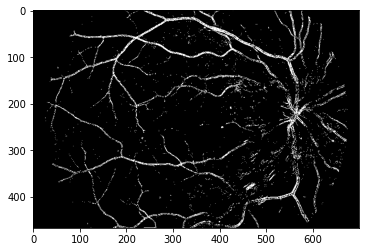

In [11]:
width, height, _ = img_test.shape
corrected_img = process_predicted_image(y_pred, preprocessed_mask, width//5, height//5)

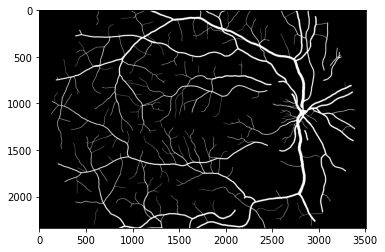

In [9]:
utils.visualize(
    image=img_test,
    manual=mask_test,
    result=corrected_img)

In [12]:
utils.print_metrics(df_test['label'], corrected_img.flatten())

Confusion matrix:

   9931   |  11465   
--------------------
   6405   |  299099  

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.96      0.61      0.97      0.77      0.61    310564
        1.0       0.46      0.61      0.96      0.53      0.77      0.56     16336

avg / total       0.95      0.95      0.63      0.95      0.77      0.60    326900



## Hyperparameter tunning with optuna

In [13]:

# source: https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py
def objective(trial):
    
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "tree_method": "exact",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }
    
    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
        
    
    clf = xgb.XGBClassifier(**param)
    
    clf.fit(X_train, y_train)
    preds = clf.predict(X_valid)
    accuracy = accuracy_score(y_valid, preds)
    return accuracy

In [14]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-10-21 16:36:57,622] A new study created in memory with name: no-name-5ffb7396-310c-49c2-b7b3-da22b3df9d77
[I 2022-10-21 16:36:59,418] Trial 0 finished with value: 0.8202978090698386 and parameters: {'booster': 'gblinear', 'lambda': 3.9613642514159406e-08, 'alpha': 0.004541449850533915, 'subsample': 0.42285412237355474, 'colsample_bytree': 0.6564880018608608}. Best is trial 0 with value: 0.8202978090698386.
[I 2022-10-21 16:37:01,200] Trial 1 finished with value: 0.8103161761490357 and parameters: {'booster': 'gblinear', 'lambda': 0.02394715131832213, 'alpha': 1.3596726983671331e-05, 'subsample': 0.2936511994108981, 'colsample_bytree': 0.7080807654762085}. Best is trial 0 with value: 0.8202978090698386.
[I 2022-10-21 16:37:08,943] Trial 2 finished with value: 0.8575130100144313 and parameters: {'booster': 'gbtree', 'lambda': 0.102540837045724, 'alpha': 1.015409181577873e-07, 'subsample': 0.5003715387489073, 'colsample_bytree': 0.5848491935640557, 'max_depth': 5, 'min_child_weigh

[I 2022-10-21 16:43:45,367] Trial 17 finished with value: 0.8760987449162548 and parameters: {'booster': 'dart', 'lambda': 1.2875457902877031e-05, 'alpha': 1.1971611123973797e-08, 'subsample': 0.5433872510949687, 'colsample_bytree': 0.8538615550186368, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.06255753078768368, 'gamma': 0.022634091967023016, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 7.587756595142519e-07, 'skip_drop': 4.236495229936779e-07}. Best is trial 17 with value: 0.8760987449162548.
[I 2022-10-21 16:43:47,191] Trial 18 finished with value: 0.8384134342064985 and parameters: {'booster': 'gblinear', 'lambda': 2.616120660445503e-06, 'alpha': 0.00012397739686005217, 'subsample': 0.535035878045601, 'colsample_bytree': 0.7991924695216632}. Best is trial 17 with value: 0.8760987449162548.
[I 2022-10-21 16:44:00,996] Trial 19 finished with value: 0.8654502120960336 and parameters: {'booster': 'gbtree', 'lambda': 3.90160017504330

[I 2022-10-21 16:52:25,616] Trial 34 finished with value: 0.875923820352473 and parameters: {'booster': 'dart', 'lambda': 0.009824139254137807, 'alpha': 1.387649327058848e-07, 'subsample': 0.7863999031437081, 'colsample_bytree': 0.886167434143009, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.30036061320068347, 'gamma': 0.13211949077990434, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.228341527266173e-08, 'skip_drop': 4.6017901228261046e-06}. Best is trial 21 with value: 0.8774325447150916.
[I 2022-10-21 16:53:01,588] Trial 35 finished with value: 0.8675165085057069 and parameters: {'booster': 'dart', 'lambda': 0.13515886831543006, 'alpha': 5.3898883541256744e-08, 'subsample': 0.7147695689159707, 'colsample_bytree': 0.20340343958462614, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.2589233691874775, 'gamma': 0.05018726170016761, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.830

[I 2022-10-21 17:00:38,821] Trial 50 finished with value: 0.8389272751126077 and parameters: {'booster': 'gblinear', 'lambda': 9.945759831828115e-07, 'alpha': 5.451613126910162e-06, 'subsample': 0.7722394232647817, 'colsample_bytree': 0.42584341060874586}. Best is trial 45 with value: 0.8778698561245463.
[I 2022-10-21 17:01:15,947] Trial 51 finished with value: 0.8781213101849827 and parameters: {'booster': 'dart', 'lambda': 8.054901625930012e-05, 'alpha': 2.3745332326598956e-07, 'subsample': 0.81963003277881, 'colsample_bytree': 0.6086004328737106, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.14369782855511673, 'gamma': 0.00039801339453513385, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0006506040888200523, 'skip_drop': 0.03368462810737116}. Best is trial 51 with value: 0.8781213101849827.
[I 2022-10-21 17:01:58,028] Trial 52 finished with value: 0.8743822976341453 and parameters: {'booster': 'dart', 'lambda': 0.000960167970076731

[I 2022-10-21 17:10:43,012] Trial 66 finished with value: 0.8701294441771986 and parameters: {'booster': 'dart', 'lambda': 3.1506787147869924e-08, 'alpha': 0.8495520908346998, 'subsample': 0.8914477607348364, 'colsample_bytree': 0.685420054153153, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.007602059503430044, 'gamma': 0.0001088057098874112, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0001379236026498424, 'skip_drop': 0.004799196363551692}. Best is trial 51 with value: 0.8781213101849827.
[I 2022-10-21 17:11:24,213] Trial 67 finished with value: 0.8772138890103642 and parameters: {'booster': 'dart', 'lambda': 2.249246694032296e-08, 'alpha': 0.009763947226932492, 'subsample': 0.8357308994736921, 'colsample_bytree': 0.6968208629992698, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.05326371607331499, 'gamma': 0.00016922623133685304, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.001103

[I 2022-10-21 17:20:24,386] Trial 82 finished with value: 0.8767765776009097 and parameters: {'booster': 'dart', 'lambda': 8.183695487110845e-08, 'alpha': 0.48652109832873563, 'subsample': 0.937980846808966, 'colsample_bytree': 0.5207304113655591, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.2418584666279856, 'gamma': 6.953293329507467e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00021557375694613386, 'skip_drop': 0.005816069576587482}. Best is trial 51 with value: 0.8781213101849827.
[I 2022-10-21 17:21:11,934] Trial 83 finished with value: 0.875595836795382 and parameters: {'booster': 'dart', 'lambda': 1.4940210220168924e-08, 'alpha': 0.01703968370159333, 'subsample': 0.8508049388528685, 'colsample_bytree': 0.6197822437458146, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.03005614443912607, 'gamma': 0.001087239886661804, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.5057807042

[I 2022-10-21 17:30:07,574] Trial 98 finished with value: 0.8783181003192373 and parameters: {'booster': 'dart', 'lambda': 1.5132846445070428e-06, 'alpha': 0.00034682276833112013, 'subsample': 0.8746553989865075, 'colsample_bytree': 0.7627095542025805, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.15912745457454466, 'gamma': 2.0542468334709736e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.6782765158488333e-05, 'skip_drop': 0.9167392721820858}. Best is trial 87 with value: 0.8784930248830192.
[I 2022-10-21 17:30:46,760] Trial 99 finished with value: 0.8687628460226527 and parameters: {'booster': 'dart', 'lambda': 1.5368907833685508e-06, 'alpha': 0.00014114064674800817, 'subsample': 0.9222453486387626, 'colsample_bytree': 0.7560715656720081, 'max_depth': 9, 'min_child_weight': 7, 'eta': 1.6957588360032267e-07, 'gamma': 1.7450820912985847e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop'

Number of finished trials:  100
Best trial:
  Value: 0.8784930248830192
  Params: 
    booster: dart
    lambda: 1.098542326937539e-07
    alpha: 0.00609759023703669
    subsample: 0.8283450540003396
    colsample_bytree: 0.5920844194139621
    max_depth: 9
    min_child_weight: 7
    eta: 0.14568856533358662
    gamma: 5.5733965760185595e-06
    grow_policy: lossguide
    sample_type: uniform
    normalize_type: tree
    rate_drop: 2.2643161257851883e-05
    skip_drop: 0.011826723138781373


# Testing optimal params

In [15]:
clf = xgb.XGBClassifier(**trial.params)

clf.fit(X_train, y_train)

XGBClassifier(alpha=0.00609759023703669, base_score=0.5, booster='dart',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5920844194139621, early_stopping_rounds=None,
              enable_categorical=False, eta=0.14568856533358662,
              eval_metric=None, gamma=5.5733965760185595e-06, gpu_id=-1,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints='', lambda=1.098542326937539e-07,
              learning_rate=0.145688564, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, normalize_type='tree', num_parallel_tree=1, ...)

In [16]:
pred = clf.predict(X_valid)
utils.print_metrics(y_valid, pred)

Confusion matrix:

  13188   |   7920   
--------------------
   3194   |  67166   

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.89      0.81      0.92      0.85      0.73     75086
          1       0.62      0.81      0.89      0.70      0.85      0.71     16382

avg / total       0.90      0.88      0.82      0.88      0.85      0.72     91468



In [17]:
y_pred = clf.predict(df_test[df_test.columns.difference(['label'])])

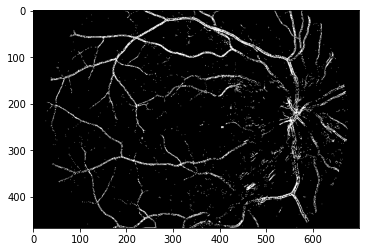

In [18]:
width, height, _ = img_test.shape
corrected_img = process_predicted_image(y_pred, preprocessed_mask, width//5, height//5)

In [ ]:
utils.visualize(
    image=img_test,
    manual=mask_test,
    result=corrected_img)

# Final train

In [13]:
X_train_final = train[train.columns.difference(['label'])]
y_train_final = train['label']
rus = RandomUnderSampler(sampling_strategy=0.6)
X_train_final, y_train_final = rus.fit_resample(X_train_final, y_train_final)

X_test_final = test[test.columns.difference(['label'])]
y_test_final = test['label']

In [20]:
clf = xgb.XGBClassifier(**trial.params)

clf.fit(X_train_final, y_train_final)

XGBClassifier(alpha=0.00609759023703669, base_score=0.5, booster='dart',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5920844194139621, early_stopping_rounds=None,
              enable_categorical=False, eta=0.14568856533358662,
              eval_metric=None, gamma=5.5733965760185595e-06, gpu_id=-1,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints='', lambda=1.098542326937539e-07,
              learning_rate=0.145688564, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, normalize_type='tree', num_parallel_tree=1, ...)

In [15]:
y_pred_final = clf.predict(X_test_final)

utils.print_metrics(y_test_final, y_pred_final)

Confusion matrix:

  97664   |  50033   
--------------------
  152617  | 1358227  

                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.96      0.39      0.93      0.61      0.40   1408260
          1       0.66      0.39      0.96      0.49      0.61      0.35    250281

avg / total       0.86      0.88      0.48      0.86      0.61      0.39   1658541



In [6]:
curr_dir_path = os.path.abspath('')
data_dir_path = os.path.join(curr_dir_path, "models")
model_path = os.path.join(data_dir_path, "xgb_optuna_model.sav")

In [22]:
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

pickle.dump(clf, open(model_path, 'wb'))

## Sample test

In [7]:
clf = pickle.load(open(model_path, 'rb'))

In [ ]:
y_pred = clf.predict(df_test[df_test.columns.difference(['label'])])

In [ ]:
width, height, _ = img_test.shape
corrected_img = process_predicted_image(y_pred, preprocessed_mask, width//5, height//5)

In [ ]:
utils.visualize(
    image=img_test,
    manual=mask_test,
    result=corrected_img)

# Results

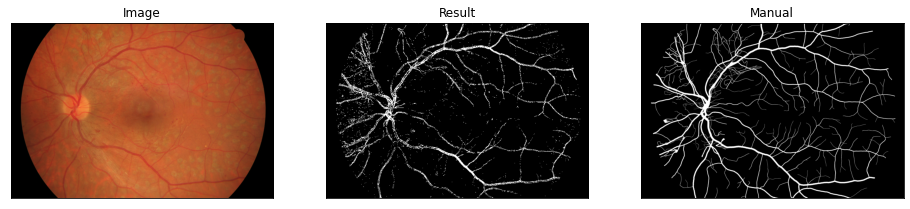

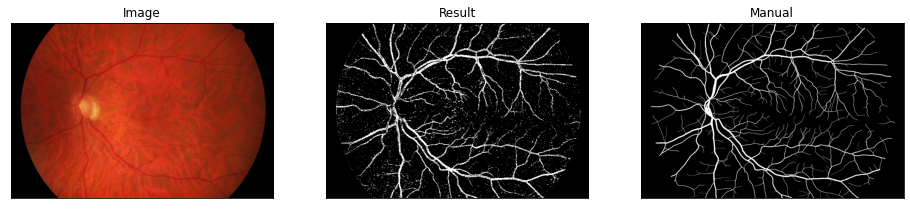

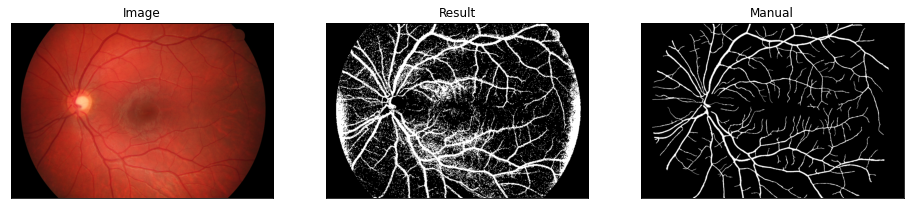

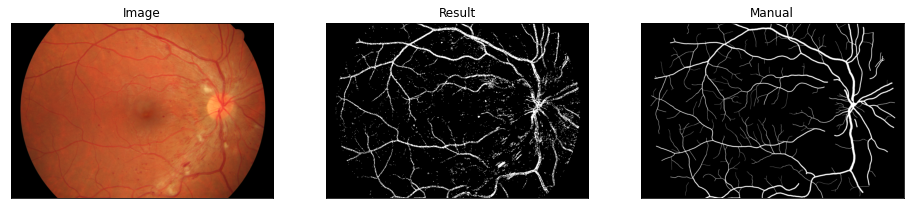

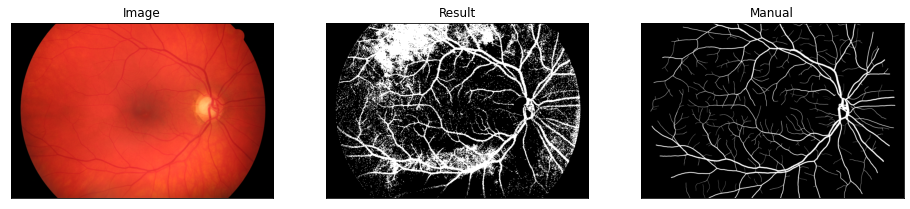

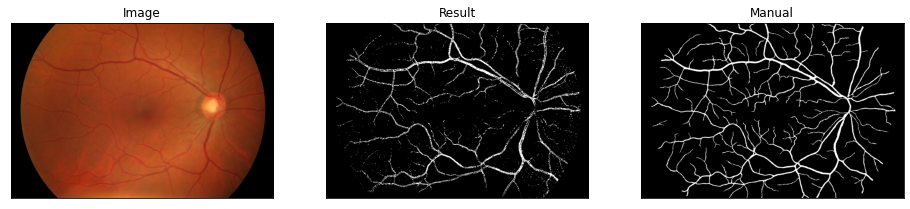

In [11]:
for i in range(14,16):
    for img_type in ('dr', 'g', 'h'):
        img_result, mask_result, manual_result = utils.load_set_of_images(i, img_type)
        df_result, preprocessed_mask_result = preprocess_image_for_ML(img_result, mask_result, manual_result, 5, 5)   
        
        pred_result = clf.predict(df_result[df_result.columns.difference(['label'])])
        
        width, height, _ = img_result.shape
        corrected_image = process_predicted_image(pred_result, preprocessed_mask_result, width//5, height//5)
        
        utils.visualize(image=img_result,
                        result=corrected_image,
                        manual=manual_result)